In [1]:
import os
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
import tqdm
import cv2
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

In [2]:
data_dir = "/srv/data/lt2326-h25/a1"
image_dir = os.path.join(data_dir, "images")
image_files = [ i for i in os.listdir(image_dir) if i.endswith("jpg")]
print(len(image_files))
print(image_files[:3])

1000
['0001261.jpg', '1002235.jpg', '0000614.jpg']


In [3]:
info_path = os.path.join(data_dir, "info.json")
with open(info_path, 'r') as f1:
    info1 = json.load(f1)
print(info1.keys())
print(len(info1['train']))
print(info1['train'][:1])

dict_keys(['test_cls', 'test_det', 'train', 'val'])
24290
[{'file_name': '0000172.jpg', 'height': 2048, 'image_id': '0000172', 'width': 2048}]


In [4]:
train_annotation_path = os.path.join(data_dir, "train.jsonl")

with open(train_annotation_path, 'r') as f2:
    first_line = f2.readline()
    annotation = json.loads(first_line)

print(annotation.keys())
print(len(annotation['annotations']))

dict_keys(['annotations', 'file_name', 'height', 'ignore', 'image_id', 'width'])
10


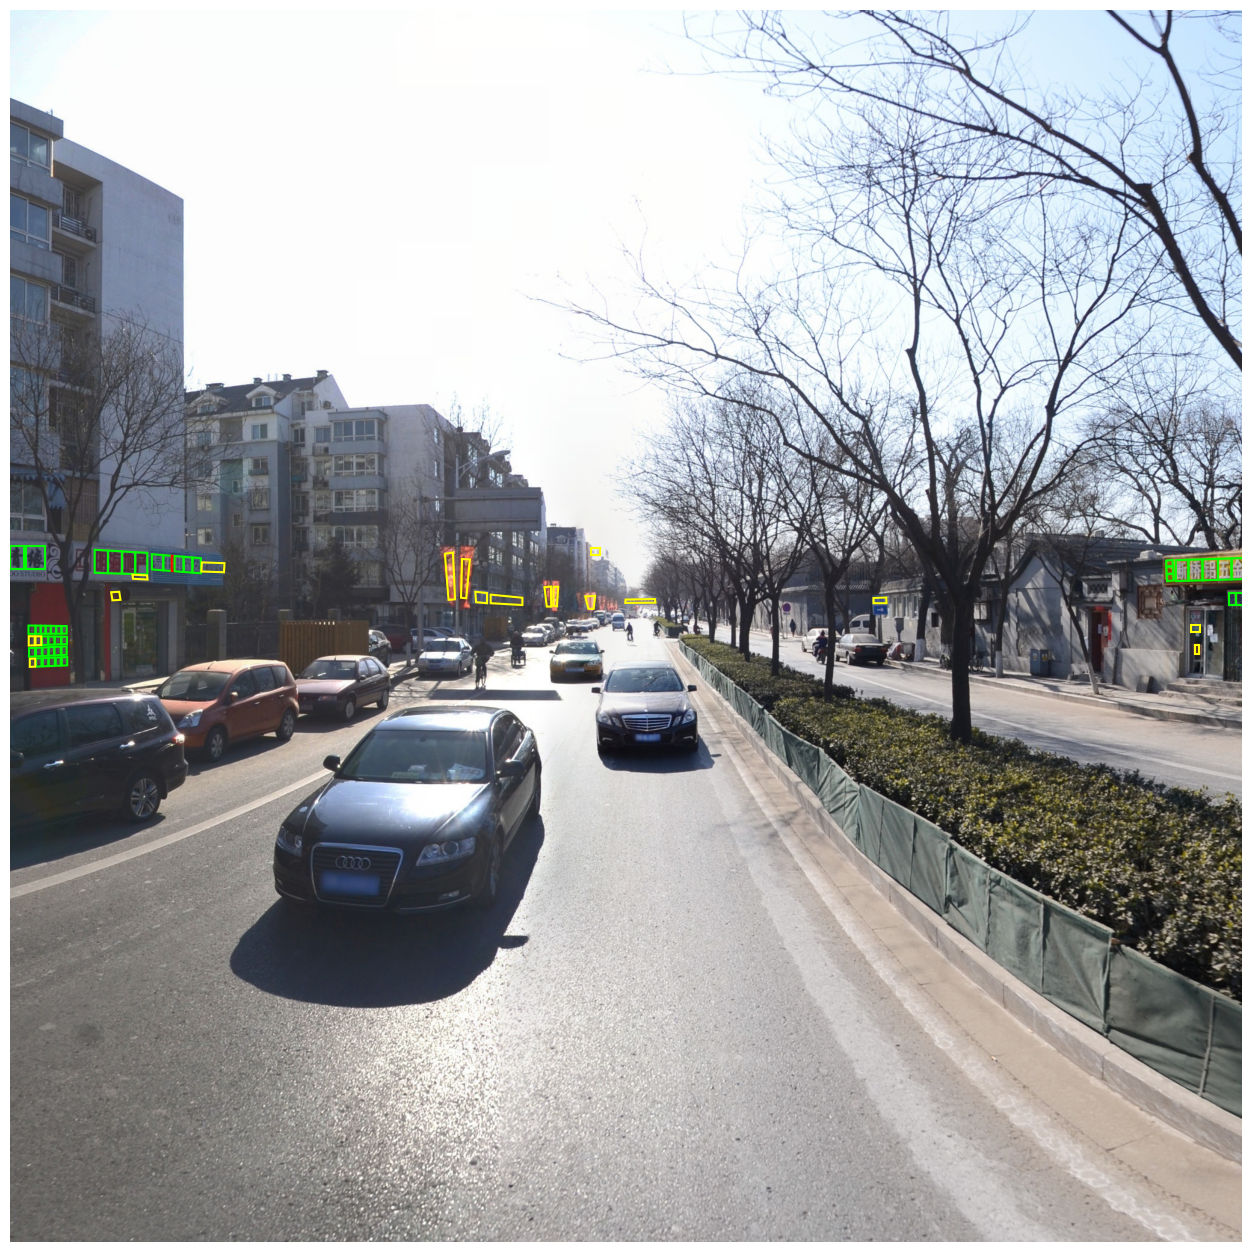

In [5]:
img_path = os.path.join(image_dir, annotation["file_name"])

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # changing the order of the colors

plt.figure(figsize=(16, 16))
ax = plt.gca()
plt.imshow(img)

for sentence in annotation['annotations']:
    for instance in sentence:
        polygon = instance["polygon"]
        is_chinese = instance["is_chinese"]
        color = (0, 1, 0) if is_chinese else (1, 0, 0)
        patch = patches.Polygon(polygon, fill=False, color=color, linewidth=1.5)
        ax.add_patch(patch)

for ignore in annotation.get("ignore", []):
    polygon = ignore["polygon"]
    patch = patches.Polygon(polygon, fill=False, color=(1, 1, 0), linewidth=1.5)
    ax.add_patch(patch)

plt.axis('off')
plt.show()

In [6]:
image_ids = [img['image_id'] for img in info1['train']]
existing_ids = [id for id in image_ids if os.path.exists(os.path.join(image_dir, f"{id}.jpg"))]
print(len(image_ids))
print(len(existing_ids))

24290
845


# Part 1

- I used the example code provided on the sourse website to visualize bounding boxes for Chinese characters.
- However, for training the model, I created binary mask images instead of using the raw polygon coordinates.
- In each mask, pixels inside a Chinese character polygon are set to 1 (white), and the rest are set to 0 (black).

These binary masks were used as ground truth for pixel-wise training.

In [7]:
class ChinCharDataset(Dataset):
    def __init__(self, image_dir, annotation_path, image_ids, image_size = (2048, 2048), transform =None):
        self.image_dir = image_dir
        self.annotation_path = annotation_path
        self.image_ids = image_ids
        self.image_size = image_size
        self.transform = transforms.ToTensor() if transform is None else transform
        self.annotation_dic = self.get_anno(annotation_path)

    def get_anno(self, path):
        anno_dic = {}
        with open(path, 'r', encoding = 'utf-8') as f3:
            for line in f3:
                item = json.loads(line)
                anno_dic[item['image_id']] = item
        return anno_dic

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, x):
        image_id = self.image_ids[x]
        image_path = os.path.join(self.image_dir, f"{image_id}.jpg")
        image = Image.open(image_path).convert("RGB")

        image_x, image_y = image.size
        small_image_x, small_image_y = self.image_size

        image = image.resize((small_image_x, small_image_y))
        image_tensor = self.transform(image)

        mask = Image.new("L", (small_image_x, small_image_y), 0) 
        draw = ImageDraw.Draw(mask)

        anno = self.annotation_dic.get(image_id, {})
        for sentence in anno.get("annotations", []):
            for i in sentence:
                if i["is_chinese"]:
                    polygon = i["polygon"]
                    small_polygon = [ (xi * small_image_x / image_x, yi*small_image_y/image_y) for xi, yi in polygon]
                    draw.polygon(small_polygon, fill=1)
        
        mask_tensor = self.transform(mask)
        
        return image_tensor, mask_tensor

- I first tried resizing the images to 256×256, but the Chinese characters became too small to recognize.
- With this small resolution, I initially built a simple linear model with flattening and no pooling, but I ran into out of memory issues.
- Even using a small portion of the dataset caused memory problems.

To solve this, I later redesigned the model to include max pooling layers. This allowed me to handle the full-size images without crashing the system.

In [8]:
with open(info_path, 'r') as f4:
    info3 = json.load(f4)
all_ids = [img['image_id'] for img in info3['train']]

image_ids = [img_id for img_id in all_ids if os.path.exists(os.path.join(image_dir, f"{img_id}.jpg"))]

In [9]:
subset_ids = image_ids[:]

train_ids, temp_ids = train_test_split(subset_ids, test_size=0.3, random_state=45)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=45)

train_dataset = ChinCharDataset(image_dir, train_annotation_path, train_ids)
val_dataset = ChinCharDataset(image_dir, train_annotation_path, val_ids)


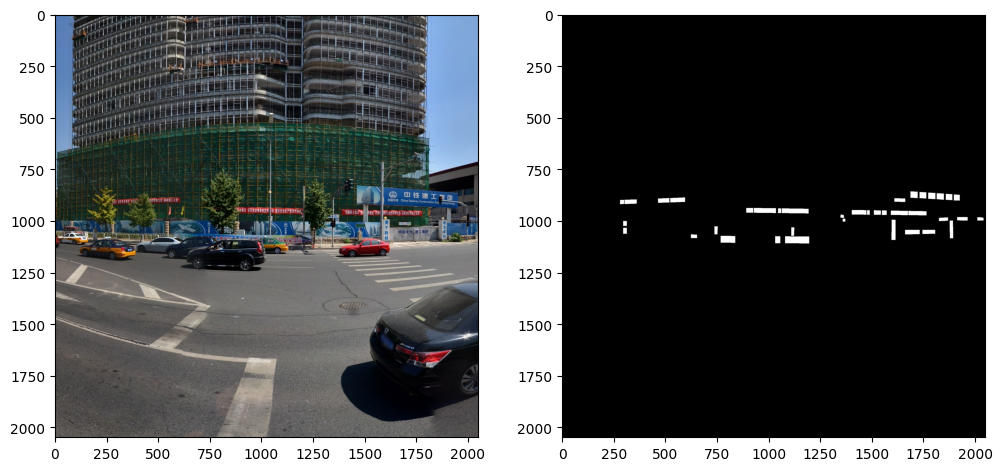

In [10]:
img_tensor, mask_tensor = train_dataset[0]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_tensor.permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.imshow(mask_tensor.squeeze(), cmap='gray')

plt.show()

# Part 2

- I initially attempted to use a simple flatten + linear model without pooling, but it didn’t work.
- I could only train on a very small fraction of the data, which was clearly not sufficient.
- So I abandoned this approach.

- Instead, I built two convolutional models. Both models take RGB images as input and output a soft binary mask indicating the probability of each pixel being part of a bounding box.

In [11]:
import torch.nn.functional as F

class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 1, kernel_size=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = F.interpolate(x, size=(2048, 2048), mode='bilinear', align_corners=False)
        return x

- Model 1 uses a basic convolutional encoder and ends with a 1x1 convolution to reduce to a single channel.
- Since the spatial dimensions are reduced due to pooling, I used F.interpolate in the forward method to upsample the output back to the original image size.
- This caused some shape mismatches during training, so I had to add an additional check inside the training loop to ensure the prediction and ground truth masks had the same shape.

In [12]:
class Model2(nn.Module): # model 2
    def __init__(self):
        super(Model2, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

- Model 2 is a slightly deeper encoder-decoder architecture with transposed convolutions (ConvTranspose2d) for upsampling.
- Instead of manually resizing the output with interpolate, it learns to reconstruct the spatial resolution through decoder layers.
- The final output is again a 1-channel prediction map.

In [17]:
device = torch.device('cuda:3')

In [18]:
def train_model(model, train_dataset, val_dataset, batch_size=1, epochs=25, lr=1e-3, device='cuda:3'):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    pos_weight = torch.tensor([20.0]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for X, y in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(X)

            if output.shape != y.shape:
                output = F.interpolate(output, size=y.shape[2:], mode='bilinear', align_corners=False)

            loss = criterion(output, y.float())
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                output = model(X_val)

                if output.shape != y_val.shape:
                    output = F.interpolate(output, size=y_val.shape[2:], mode='bilinear', align_corners=False)

                loss = criterion(output, y_val.float())
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        model_name = model.__class__.__name__
        model_path = f"best_model_{model_name}.pt"
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print(f"Saved new best model '{model_path}' at epoch {epoch+1}")

    return model

- While training, I first tried using the standard BCELoss, but the results were very poor — visually inspecting the predictions showed that the model was not learning meaningful segmentation.
- So I switched to BCEWithLogitsLoss, which combines a sigmoid layer and binary cross-entropy
- I also added a pos_weight to handle the class imbalance between character pixels and background.
- Since BCEWithLogitsLoss expects raw logits, I removed any sigmoid activation from the previous models.

- The train_model function handles both training and validation phases in each epoch.
- It keeps track of the loss and saves the model whenever the validation loss improves.
- The function also includes a shape check and resizing step to avoid mismatches between prediction and ground truth dimensions, which was especially important for Model 1.

Both models were trained using the same loss function and optimizer (Adam). I logged the training and validation loss across epochs for later analysis.

In [19]:
model1= train_model(Model1(),train_dataset,val_dataset, epochs=25)

Epoch 1/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:23<00:00,  7.09it/s]


[Epoch 1] Train Loss: 0.0147 | Val Loss: 0.0034
Saved new best model 'best_model_Model1.pt' at epoch 1


Epoch 2/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:24<00:00,  6.98it/s]


[Epoch 2] Train Loss: 0.0037 | Val Loss: 0.0032
Saved new best model 'best_model_Model1.pt' at epoch 2


Epoch 3/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:26<00:00,  6.81it/s]


[Epoch 3] Train Loss: 0.0034 | Val Loss: 0.0030
Saved new best model 'best_model_Model1.pt' at epoch 3


Epoch 4/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:26<00:00,  6.87it/s]


[Epoch 4] Train Loss: 0.0034 | Val Loss: 0.0030
Saved new best model 'best_model_Model1.pt' at epoch 4


Epoch 5/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:26<00:00,  6.80it/s]


[Epoch 5] Train Loss: 0.0034 | Val Loss: 0.0030
Saved new best model 'best_model_Model1.pt' at epoch 5


Epoch 6/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:27<00:00,  6.75it/s]


[Epoch 6] Train Loss: 0.0033 | Val Loss: 0.0029
Saved new best model 'best_model_Model1.pt' at epoch 6


Epoch 7/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:27<00:00,  6.76it/s]


[Epoch 7] Train Loss: 0.0033 | Val Loss: 0.0033


Epoch 8/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:26<00:00,  6.80it/s]


[Epoch 8] Train Loss: 0.0033 | Val Loss: 0.0028
Saved new best model 'best_model_Model1.pt' at epoch 8


Epoch 9/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:26<00:00,  6.84it/s]


[Epoch 9] Train Loss: 0.0033 | Val Loss: 0.0028


Epoch 10/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:27<00:00,  6.79it/s]


[Epoch 10] Train Loss: 0.0032 | Val Loss: 0.0029


Epoch 11/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:27<00:00,  6.78it/s]


[Epoch 11] Train Loss: 0.0032 | Val Loss: 0.0028
Saved new best model 'best_model_Model1.pt' at epoch 11


Epoch 12/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:28<00:00,  6.71it/s]


[Epoch 12] Train Loss: 0.0032 | Val Loss: 0.0027
Saved new best model 'best_model_Model1.pt' at epoch 12


Epoch 13/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:28<00:00,  6.71it/s]


[Epoch 13] Train Loss: 0.0032 | Val Loss: 0.0028


Epoch 14/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:27<00:00,  6.74it/s]


[Epoch 14] Train Loss: 0.0031 | Val Loss: 0.0027
Saved new best model 'best_model_Model1.pt' at epoch 14


Epoch 15/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:28<00:00,  6.71it/s]


[Epoch 15] Train Loss: 0.0031 | Val Loss: 0.0027


Epoch 16/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:33<00:00,  6.30it/s]


[Epoch 16] Train Loss: 0.0031 | Val Loss: 0.0027
Saved new best model 'best_model_Model1.pt' at epoch 16


Epoch 17/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:31<00:00,  6.45it/s]


[Epoch 17] Train Loss: 0.0030 | Val Loss: 0.0027
Saved new best model 'best_model_Model1.pt' at epoch 17


Epoch 18/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:31<00:00,  6.47it/s]


[Epoch 18] Train Loss: 0.0031 | Val Loss: 0.0027


Epoch 19/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:31<00:00,  6.48it/s]


[Epoch 19] Train Loss: 0.0031 | Val Loss: 0.0026
Saved new best model 'best_model_Model1.pt' at epoch 19


Epoch 20/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:31<00:00,  6.43it/s]


[Epoch 20] Train Loss: 0.0030 | Val Loss: 0.0026
Saved new best model 'best_model_Model1.pt' at epoch 20


Epoch 21/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:30<00:00,  6.52it/s]


[Epoch 21] Train Loss: 0.0030 | Val Loss: 0.0026
Saved new best model 'best_model_Model1.pt' at epoch 21


Epoch 22/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:32<00:00,  6.42it/s]


[Epoch 22] Train Loss: 0.0030 | Val Loss: 0.0028


Epoch 23/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:31<00:00,  6.43it/s]


[Epoch 23] Train Loss: 0.0030 | Val Loss: 0.0027


Epoch 24/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:33<00:00,  6.34it/s]


[Epoch 24] Train Loss: 0.0030 | Val Loss: 0.0026


Epoch 25/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:33<00:00,  6.34it/s]


[Epoch 25] Train Loss: 0.0029 | Val Loss: 0.0026


In [20]:
model2= train_model(Model2(),train_dataset,val_dataset, epochs=25)

Epoch 1/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.41it/s]


[Epoch 1] Train Loss: 0.0266 | Val Loss: 0.0035
Saved new best model 'best_model_Model2.pt' at epoch 1


Epoch 2/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.38it/s]


[Epoch 2] Train Loss: 0.0038 | Val Loss: 0.0035
Saved new best model 'best_model_Model2.pt' at epoch 2


Epoch 3/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:50<00:00,  5.37it/s]


[Epoch 3] Train Loss: 0.0038 | Val Loss: 0.0034
Saved new best model 'best_model_Model2.pt' at epoch 3


Epoch 4/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.38it/s]


[Epoch 4] Train Loss: 0.0037 | Val Loss: 0.0032
Saved new best model 'best_model_Model2.pt' at epoch 4


Epoch 5/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.39it/s]


[Epoch 5] Train Loss: 0.0036 | Val Loss: 0.0033


Epoch 6/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.40it/s]


[Epoch 6] Train Loss: 0.0036 | Val Loss: 0.0032
Saved new best model 'best_model_Model2.pt' at epoch 6


Epoch 7/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:48<00:00,  5.43it/s]


[Epoch 7] Train Loss: 0.0036 | Val Loss: 0.0032
Saved new best model 'best_model_Model2.pt' at epoch 7


Epoch 8/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.38it/s]


[Epoch 8] Train Loss: 0.0035 | Val Loss: 0.0033


Epoch 9/25 - Training: 100%|██████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.38it/s]


[Epoch 9] Train Loss: 0.0035 | Val Loss: 0.0031
Saved new best model 'best_model_Model2.pt' at epoch 9


Epoch 10/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.38it/s]


[Epoch 10] Train Loss: 0.0035 | Val Loss: 0.0031


Epoch 11/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.38it/s]


[Epoch 11] Train Loss: 0.0035 | Val Loss: 0.0030
Saved new best model 'best_model_Model2.pt' at epoch 11


Epoch 12/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.39it/s]


[Epoch 12] Train Loss: 0.0034 | Val Loss: 0.0030


Epoch 13/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.38it/s]


[Epoch 13] Train Loss: 0.0034 | Val Loss: 0.0031


Epoch 14/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.38it/s]


[Epoch 14] Train Loss: 0.0034 | Val Loss: 0.0030


Epoch 15/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.38it/s]


[Epoch 15] Train Loss: 0.0034 | Val Loss: 0.0029
Saved new best model 'best_model_Model2.pt' at epoch 15


Epoch 16/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.38it/s]


[Epoch 16] Train Loss: 0.0033 | Val Loss: 0.0030


Epoch 17/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:47<00:00,  5.49it/s]


[Epoch 17] Train Loss: 0.0033 | Val Loss: 0.0029
Saved new best model 'best_model_Model2.pt' at epoch 17


Epoch 18/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:48<00:00,  5.46it/s]


[Epoch 18] Train Loss: 0.0033 | Val Loss: 0.0028
Saved new best model 'best_model_Model2.pt' at epoch 18


Epoch 19/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.38it/s]


[Epoch 19] Train Loss: 0.0032 | Val Loss: 0.0030


Epoch 20/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.39it/s]


[Epoch 20] Train Loss: 0.0032 | Val Loss: 0.0028
Saved new best model 'best_model_Model2.pt' at epoch 20


Epoch 21/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:48<00:00,  5.44it/s]


[Epoch 21] Train Loss: 0.0032 | Val Loss: 0.0028
Saved new best model 'best_model_Model2.pt' at epoch 21


Epoch 22/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:48<00:00,  5.44it/s]


[Epoch 22] Train Loss: 0.0031 | Val Loss: 0.0028


Epoch 23/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:49<00:00,  5.42it/s]


[Epoch 23] Train Loss: 0.0031 | Val Loss: 0.0028


Epoch 24/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:48<00:00,  5.45it/s]


[Epoch 24] Train Loss: 0.0031 | Val Loss: 0.0027
Saved new best model 'best_model_Model2.pt' at epoch 24


Epoch 25/25 - Training: 100%|█████████████████████████████████████████████████████████| 591/591 [01:48<00:00,  5.43it/s]


[Epoch 25] Train Loss: 0.0031 | Val Loss: 0.0027
Saved new best model 'best_model_Model2.pt' at epoch 25


# Part 3

- I trained both Model 1 and Model 2 for 25 epochs each using the same training and validation datasets.
- Both models optimized the BCEWithLogitsLoss with a pos_weight.
- Model 1 reached its best validation loss of 0.0026 at epoch 19.
- Model 2 reached its best validation loss of 0.0027 at epoch 24.
- both models were able to learn meaningful features, but Model 1 slightly outperformed Model 2 in validation loss and training efficiency as Model 1 was faster per epoch

In [28]:
test_dataset = ChinCharDataset(image_dir, train_annotation_path, test_ids)

In [29]:
def example_prediction(model, dataset, index=0):
    model.eval()
    model.to(device)
    image, true_mask = dataset[index]
    image = image.unsqueeze(0).to(device)
    true_mask = true_mask.squeeze().cpu()
    print(image.size())
    
    with torch.no_grad():
        logits = model(image)
        pred_mask = torch.sigmoid(logits)[0, 0].cpu()
        
    print(pred_mask.min(), pred_mask.max())
    
    #pred_mask.cpu()
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image[0].cpu().permute(1, 2, 0))

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap="gray")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    
    plt.show()

- To qualitatively evaluate the models, I overlaid the predicted mask (after applying sigmoid and a threshold) on original test images.

torch.Size([1, 3, 2048, 2048])
tensor(4.8507e-07) tensor(0.0634)


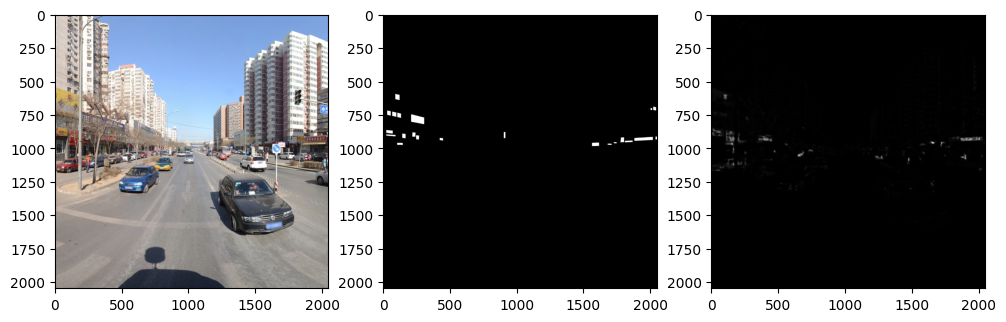

In [41]:
example_prediction(model1, test_dataset, index=6)

torch.Size([1, 3, 2048, 2048])
tensor(3.9291e-06) tensor(0.0921)


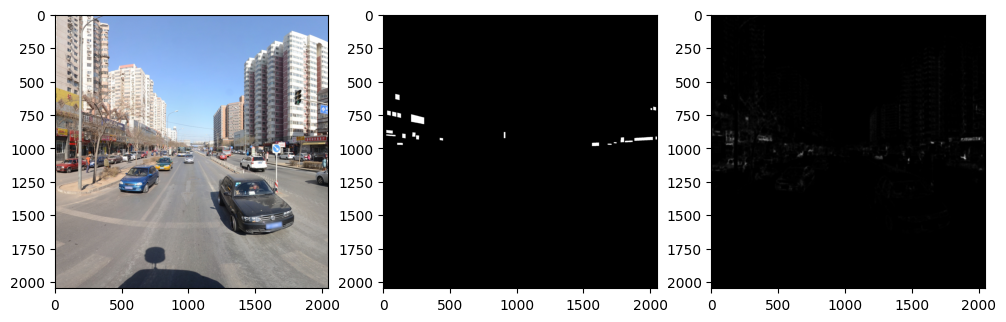

In [42]:
example_prediction(model2, test_dataset, index=6)

- Both models are able to roughly identify the location of Chinese characters
- Model 1 generally produces higher confidence, resulting in brighter predictions.
- Model 2 predictions tend to be more conservative, but the structure of text regions is still visible.
- In both models, smaller characters with low contrast are harder to detect accurately.

Because traditional binary classification metrics (e.g. precision, recall) were not informative due to heavy class imbalance (very few foreground pixels), I chose to report MSE between the predicted probability map and ground truth binary mask.

In [32]:
def evaluate_mse(model, dataset, device='cuda:2'):
    model.eval()
    model.to(device)
    mse_total = 0
    count = 0

    with torch.no_grad():
        for img, mask in dataset:
            img = img.unsqueeze(0).to(device)
            mask = mask.unsqueeze(0).to(device)

            outputs = model(img)
            probs = torch.sigmoid(outputs)

            mse = F.mse_loss(probs, mask.float())
            mse_total += mse.item()
            count += 1

    avg_mse = mse_total / count
    return avg_mse

In [33]:
evaluate_mse_model1 = evaluate_mse(model1,  test_dataset)
evaluate_mse_model1

1.7493585754503178e-06

In [34]:
evaluate_mse_model2 = evaluate_mse(model2,  test_dataset)
evaluate_mse_model2

4.2501162079894685e-06

- Model 1 achieved lower mean squared error, indicating better alignment with the ground truth masks.
- Although the difference is small, it supports the earlier observation that Model 1 slightly outperforms Model 2 in this task.